In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/Dataset100KForNERWords.csv', 
                    usecols=['sentença',
                             'Palavra', 
                             'Word2idx', 
                             'classOfWords']) # importando nosso
                                              # Dataset

In [3]:
sentenças = data['sentença'].to_list()
Word2idx = data['Word2idx'].to_list()
classOfWords = data['classOfWords'].to_list()

In [4]:
# mudando as tags
# de = {'O': 0,   para = {'O': 1,     
#  'I-Cla': 1,            'Cla': 2,
#  'I-Seg': 2,            'Seg': 3,
#  'I-Jur': 3,            'Jur': 4,
#  'I-FiM': 4,            'FiM': 5,
#  'B-FiF': 5,            'FiF': 6,
#  'I-FiF': 6,            'Gov': 7,
#  'B-Jur': 7,            'Ass': 8,
#  'B-FiM': 8,            'Val': 9}
#  'I-Gov': 9,
#   'I-Ass': 10,
#   'B-Gov': 11,
#   'B-Ass': 12,
#   'B-Cla': 13,
#   'B-Seg': 14,
#   'B-Val': 15,
#   'I-Val': 16}

new_classOfWords = []
for y in classOfWords:
    if (y == 13):# Cla
        new_classOfWords.append(2)
    if (y == 14): # Seg
        new_classOfWords.append(3)
    if (y == 7): # Jur
        new_classOfWords.append(4)
    if (y == 8): # FiM
        new_classOfWords.append(5)
    if (y == 6): # Fif
        new_classOfWords.append(6)
    if (y == 9 or y == 11): # Gov
        new_classOfWords.append(7)
    if (y == 10 or y ==12): # Ass
        new_classOfWords.append(8)
    if (y == 15 or y ==16): # Val
        new_classOfWords.append(9)
    if (y in [0,1,2,3,4,5]):
        new_classOfWords.append(y+1)
len(new_classOfWords), len(classOfWords)

(16438905, 16438905)

In [5]:
# construindo as sentenças

i = 0
X_seq = []
Y_seq = []
unique, inicio = np.unique(sentenças,return_index=True)

for i,ind in enumerate(inicio):

    if (i != 87918):
        X_seq.append(Word2idx[ind:inicio[i+1]])
        Y_seq.append(new_classOfWords[ind:inicio[i+1]])
    else:
        X_seq.append(Word2idx[ind:])
        Y_seq.append(new_classOfWords[ind:])


In [6]:
maxs = [np.max(seq) for seq in X_seq] # apenas para saber qual é o tamanho do vocabulário
np.max(maxs)

366549

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
max_len = 150
y = pad_sequences(maxlen=max_len, sequences=Y_seq, padding="post",truncating='post') # aplicando padding nas classes

In [9]:
X = pad_sequences(maxlen=max_len, sequences=X_seq, padding="post",truncating='post') # aplicando padding nas sentenças

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123) # dividindo em teste e treino

In [12]:
tag2idx = {'O': 1,
           'Cla': 2,
           'Seg': 3,
           'Jur': 4,
           'FiM': 5,
           'FiF': 6,
           'Gov': 7,
           'Ass': 8,
           'Val': 9} # dicionário de tags [apenas para labels]

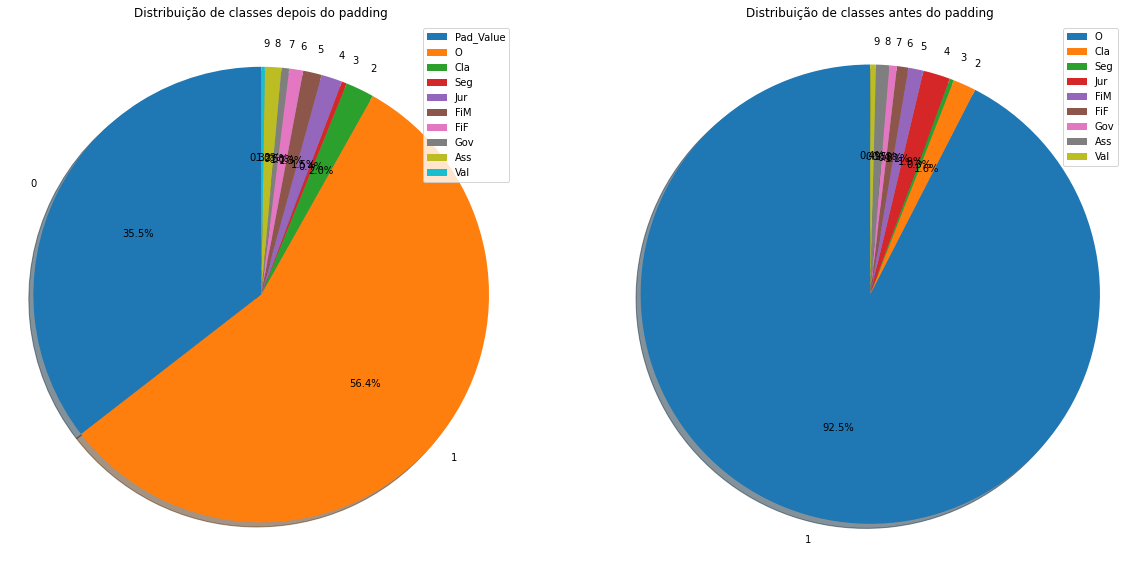

In [13]:
concate_Y_seq= np.asarray([element for y_seq in y_tr for element in y_seq])
labels,sizes = np.unique(concate_Y_seq, return_counts=True)

lab = list(tag2idx.keys())
lab.insert(0, 'Pad_Value')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(lab)
ax1.set_title('Distribuição de classes depois do padding')

concate_Y_seq= np.asarray([element for y_seq in Y_seq for element in y_seq])
labels,sizes = np.unique(concate_Y_seq, return_counts=True)
ax2.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(list(tag2idx.keys()))
ax2.set_title('Distribuição de classes antes do padding')

plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional, Input, Masking

tf.__version__, tf.executing_eagerly()

('2.3.0', True)

In [15]:
units = 512 # output da LSTM
Emb_dims = 50 # tamanho do vetor de embeddings
Spa_dropout = 0.5 # spacial dropout rate
n_tags = 10 # quantidade de tags

model = Sequential()
model.add(Input(shape=(None,)))
model.add(Embedding(input_dim=np.max(maxs) + 1, output_dim=Emb_dims, mask_zero=True))
model.add(SpatialDropout1D(Spa_dropout))
model.add(Bidirectional(LSTM(units=units, return_sequences=True), merge_mode='sum'))
model.add(Dense(n_tags, activation="softmax"))

In [16]:
### definindo metricas customizadas

def recall(y_true, y_pred):
    y_pred = tf.cast(K.argmax(y_pred), tf.float32) # transformando o vetor de (None, 150, n_tags) para (None, 150)
    macro_recall = 0
    y_pred = y_pred[y_true != 0] # retira zero
    y_true = y_true[y_true != 0] # retira zero
    equals = y_pred[K.equal(y_true,y_pred)]  # calcula os verdadeiros positivos, ignorando o zero
    
    for i in range(1,n_tags):
        equals_positives = equals[equals == i]  
        true_positives = K.sum(equals_positives/i) # divide por i, para que os valores se tornem 1

        equals_possibles = y_true[K.equal(y_true,K.constant(i))]/i
        possible_positives = K.sum(equals_possibles)

        recall = true_positives / (possible_positives + K.epsilon())
        macro_recall = macro_recall + recall

    macro_recall = macro_recall/(n_tags-1)  

    return macro_recall

def precision(y_true, y_pred):
    y_pred = tf.cast(K.argmax(y_pred), tf.float32) # trannsformando o vetor de (None, 150, n_tags) para (None, 150)
    macro_precision = 0
    y_pred = y_pred[y_true != 0] # retira zero
    y_true = y_true[y_true != 0] # retira zero
    equals = y_true[K.equal(y_true,y_pred)]  # calcula os verdadeiros positivos, ignorando o zero
    
    for i in range(1,n_tags):
        equals_positives = equals[equals == i]  
        true_positives = K.sum(equals_positives/i) # divide por i, para que os valores se tornem 1

        equals_pred_possibles = y_pred[K.equal(y_pred,K.constant(i))]/i
        predicted_positives = K.sum(equals_pred_possibles)

        precision = true_positives / (predicted_positives + K.epsilon())
        macro_precision = macro_precision + precision

    macro_precision = macro_precision/(n_tags-1)

    return macro_precision

def macro_f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [17]:
model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["SparseCategoricalAccuracy",
              recall,
              precision,
              macro_f1])

In [18]:
import time
import os

start = time.time()
bs = 128
model.fit(X_tr,y_tr,
          validation_data=(X_te, y_te),
          epochs = 10,
          batch_size = bs)

print('O modelo levou {} s durante o treino.'.format(time.time()-start))

# just a beep to know when end
duration = 1  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

Epoch 1/10
619/619 [==============================] - 251s 406ms/step - loss: 0.1535 - sparse_categorical_accuracy: 0.9306 - recall: 0.5305 - precision: 0.6227 - macro_f1: 0.5705 - val_loss: 0.0782 - val_sparse_categorical_accuracy: 0.9621 - val_recall: 0.7975 - val_precision: 0.8173 - val_macro_f1: 0.8070
Epoch 2/10
619/619 [==============================] - 247s 399ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9670 - recall: 0.8064 - precision: 0.8599 - macro_f1: 0.8318 - val_loss: 0.0596 - val_sparse_categorical_accuracy: 0.9709 - val_recall: 0.8647 - val_precision: 0.8606 - val_macro_f1: 0.8624
Epoch 3/10
619/619 [==============================] - 244s 395ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9753 - recall: 0.8627 - precision: 0.8948 - macro_f1: 0.8781 - val_loss: 0.0553 - val_sparse_categorical_accuracy: 0.9728 - val_recall: 0.8447 - val_precision: 0.8982 - val_macro_f1: 0.8704
Epoch 4/10
619/619 [==============================] - 250s 404ms/step - loss

In [19]:
name = 'Models/UseForPreprocessing_Max_len{}_Emb{}_SDrop1D{}_Bid{}_Den{}_bs{}_NoPadding_valuestags+1.h5'.format(max_len, Emb_dims, Spa_dropout, units, n_tags, bs)
model.save(name)

In [20]:
# função que plota gráficos do keras
# recebe um dicionário do history do model e um string de nome da métrica
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

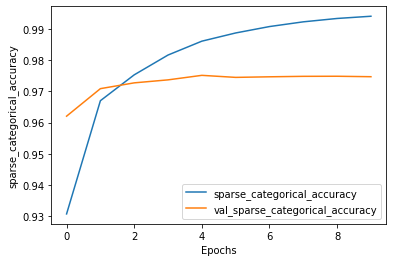

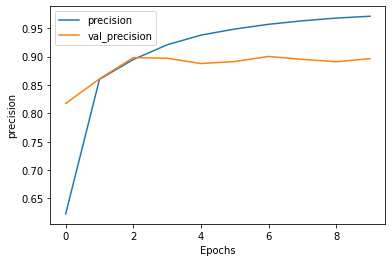

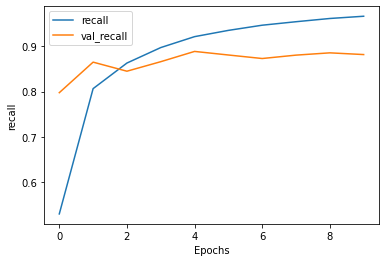

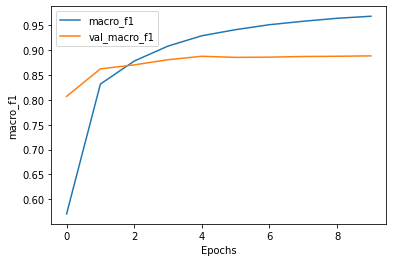

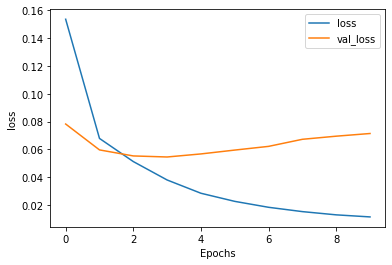

In [21]:
plot_graphs(model.history, 'sparse_categorical_accuracy')
plot_graphs(model.history, 'precision')
plot_graphs(model.history, 'recall')
plot_graphs(model.history, 'macro_f1')
plot_graphs(model.history, 'loss')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [23]:
y_pred = []

pred = model.predict(X_te, batch_size=128) # fazendo a predição para as amostras de teste

for p in pred: # apenas transofrmando-as em um grande vetor de predições
    for word in p:
        y_pred.append(np.argmax(word))

In [24]:
y_pred = np.array(y_pred) # transformando em array
y_true = np.array([tag for word in y_te for tag in word]) # deixando uni dimensiona o vetor de classes verdadeiros

y_pred = y_pred[y_true != 0] # retirando do pred aquelas posições de padding
y_true = y_true[y_true != 0] # mesmo para as classes reais

conf_mat = confusion_matrix(y_true, np.array(y_pred)) # calculando a matriz de confusão

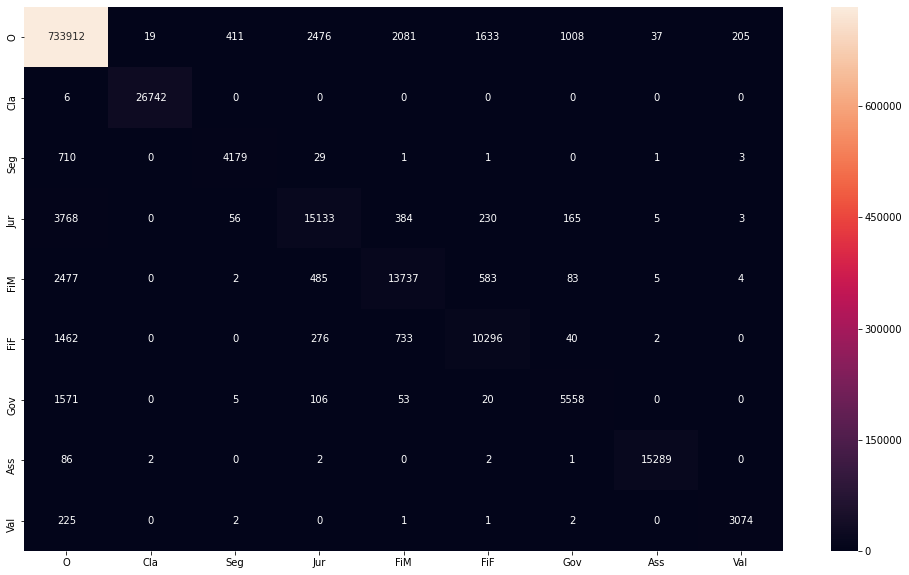

In [25]:
class_names = list(tag2idx.keys())
fig = plt.figure(figsize=(17,10))
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap

In [26]:
scores = classification_report(y_true, 
y_pred, target_names=class_names)
print(scores) 

              precision    recall  f1-score   support

           O       0.99      0.99      0.99    741782
         Cla       1.00      1.00      1.00     26748
         Seg       0.90      0.85      0.87      4924
         Jur       0.82      0.77      0.79     19744
         FiM       0.81      0.79      0.80     17376
         FiF       0.81      0.80      0.81     12809
         Gov       0.81      0.76      0.78      7313
         Ass       1.00      0.99      1.00     15382
         Val       0.93      0.93      0.93      3305

    accuracy                           0.97    849383
   macro avg       0.90      0.88      0.89    849383
weighted avg       0.97      0.97      0.97    849383



### vendo nos dados de treino mesmo, apenas para comparar as métricas durante o treino

In [27]:
y_pred_treino = []

pred = model.predict(X_tr, batch_size=128)

for p in pred:
    for word in p:
        y_pred_treino.append(np.argmax(word))

In [28]:
y_pred_treino = np.array(y_pred_treino)
y_true_treino = np.array([tag for word in y_tr for tag in word])

y_pred_treino = y_pred_treino[y_true_treino != 0]
y_true_treino = y_true_treino[y_true_treino != 0]

conf_mat = confusion_matrix(y_true_treino, np.array(y_pred_treino))

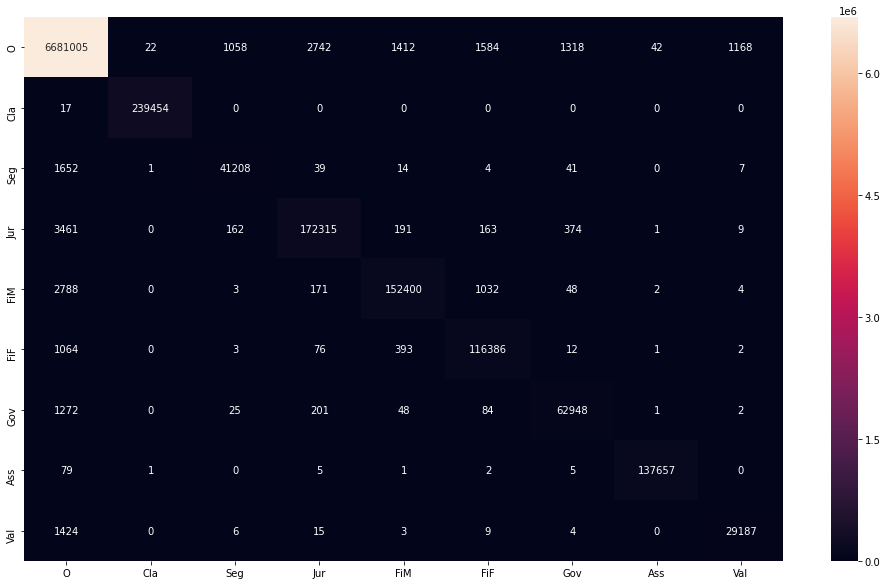

In [29]:
class_names = list(tag2idx.keys())
fig = plt.figure(figsize=(17,10))
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap

In [30]:
scores = classification_report(y_true_treino, 
y_pred_treino, target_names=class_names)
print(scores) 

              precision    recall  f1-score   support

           O       1.00      1.00      1.00   6690351
         Cla       1.00      1.00      1.00    239471
         Seg       0.97      0.96      0.96     42966
         Jur       0.98      0.98      0.98    176676
         FiM       0.99      0.97      0.98    156448
         FiF       0.98      0.99      0.98    117937
         Gov       0.97      0.97      0.97     64581
         Ass       1.00      1.00      1.00    137750
         Val       0.96      0.95      0.96     30648

    accuracy                           1.00   7656828
   macro avg       0.98      0.98      0.98   7656828
weighted avg       1.00      1.00      1.00   7656828



In [31]:
### printa igual ao accuracy e SparseCategoricalAccuracy do keras 
# def prec(y_true, y_pred):
#     y_pred = tf.cast(K.argmax(y_pred), tf.float32) # trannsformando o vetor de (None, 150, n_tags) para (None, 150)
#     y_pred = y_pred[y_true != 0]
#     y_true = y_true[y_true != 0]
#     equals = y_true[K.equal(y_true,y_pred)]  # calcula os verdadeiros positivos, ignorando o zero
#     equal = K.sum(K.clip(equals,0,1))

#     total = K.sum(K.clip(y_true,1,1))
#     return equal/total